In [1]:
# %%
# %%
# %%
import sys
from pathlib import Path
from os.path import dirname, abspath
d = dirname(abspath(Path.cwd()))
sys.path.insert(0, d)

# %%
from copy import deepcopy
from Models.shap_models import ModelWrapper
from Utils.SkorchUtils.datasets import MyDatasetSingle
from sklearn.model_selection import train_test_split
import Utils.dbutils as dbutils
from Utils.experiments_utils import save_norm_info
from Utils.feature_set_info import FeatureSetInfo
import Generators.CohortGenerator as CohortGenerator
import Generators.FeatureGenerator as FeatureGenerator
import config
#bsi_tl_recon*
# %% [markdown]
# ## Imports and GPU setup

# %%
from copy import deepcopy
from Utils.SkorchUtils.datasets import MyDatasetSingle
from sklearn.model_selection import train_test_split
import Utils.dbutils as dbutils
from Utils.feature_set_info import FeatureSetInfo
import Generators.CohortGenerator as CohortGenerator
import Generators.FeatureGenerator as FeatureGenerator
import config

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

import os.path
import pickle

import warnings
from skorch.exceptions import SkorchWarning
warnings.filterwarnings('ignore', category=SkorchWarning)

from Utils.data_utils import get_data
import config

from Utils.experiments_utils import ExperimentConducterTransferLearning

from Utils.data_getter import DataGetter
from Utils.model_params_init import get_model_params

from collections import OrderedDict

# from torch.optim import Optimizer
import seaborn as sns
import gc

import hyper_params

import math

import math
from torch.utils.data import DataLoader

import random

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 13

# %%
assert(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(hyper_params.DEVICE_NUM)

print("Folder Num: ", hyper_params.ADDITIONAL_NAME)


##%% 
if hyper_params.SEED_NUMBER is not None:
    seed_num = hyper_params.SEED_NUMBER
    print("Seed: ", seed_num)
    torch.manual_seed(seed_num)
    random.seed(seed_num)
    np.random.seed(seed_num)
    torch.use_deterministic_algorithms(True)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
# %% [markdown]
# Some parameters:

# %%
SHOULD_USE_CACHE = False
NUM_MESUREMENTS = 100 #00 #100 #600
SHOULD_UPLOAD_SAVED_FEATURESET_INFO = True
SHOULD_DO_GRID_SEARCH = False
embedding_dim = 300 # size of embedding, must be multiple of number of heads
NUM_HOURS_FOR_WINDOW = hyper_params.NUM_HOURS_FOR_WINDOW
MODEL_NAME = "Transformer"
ADDITIONAL_NAME_FOR_EXPERIMENT = hyper_params.CURR_TASK + ("" if hyper_params.CONDUCT_TRANSFER_LEARNING else '_no_transfer') + ("" if not hyper_params.USE_RNN else "_rnn") + ("" if not hyper_params.USE_LSTM else "_lstm") + \
    hyper_params.ADDITIONAL_NAME
NUM_MOST_IMPORTANT_FEATURES = -1 #600 #587
SHOULD_USE_WEIGHTS = False
NUM_EXPERIMENTS = hyper_params.NUM_EXPERIMENTS
TASK = 'mimiciv_' + hyper_params.CURR_TASK + '_' + str(NUM_MESUREMENTS) + '_' +str(NUM_HOURS_FOR_WINDOW) +'h'
CONVERT_TWO = {10: '_19', 20: '_3_20', 100: '_100_2_1', 200: '_100_1', 1:'_1_1'}
MORTALITY_TRANSFORMER_INIT_WEGITHS_LOCATION = hyper_params.LOCATION_WEIGHTS
FEATURESET_FILE_NAME = None
HIDDEN_SIZE = {100: 1, 20: 1, 10: 2, 1:1}
NUM_ATTENTION_HEADS = HIDDEN_SIZE[NUM_MESUREMENTS]
SHOULD_UPDATE_DATA = not SHOULD_UPLOAD_SAVED_FEATURESET_INFO

MODEL_LOC = "outputs/MIMICIV-Experiments/ratchet_tl/best_best_model_Transformerbsi"

DF_PRECENTAGE = hyper_params.DF_PRECENTAGE 
# %% [markdown]
# ## Cohort, Outcome and Feature Collection
# 
# ### 1. Set up a connection to the OMOP CDM database
# 
# Parameters for connection to be specified in ./config.py

# %%
schema_name = '"' + TASK  + '_test"' # all created tables will be created using this schema
cohort_name = '"' + '__' + TASK + '_cohort"'
reset_schema = False # if true, rebuild all data from scratch

# %%
# database connection parameters
database_name = config.DB_NAME
config_path = 'postgresql://{database_name}'.format(
    database_name = database_name
)
connect_args = {"host": '/var/run/postgresql/', 'user': config.PG_USERNAME, 
                'password': config.PG_PASSWORD, 'database': config.DB_NAME} # connect_args to pass to sqlalchemy create_engine function

# schemas 
cdm_schema_name = config.OMOP_CDM_SCHEMA # the name of the schema housing your OMOP CDM tables


# set up database, reset schemas as needed
db = dbutils.Database(config_path, schema_name, connect_args, cdm_schema_name)
if reset_schema:
    db.execute(
        'drop schema if exists {} cascade'.format(schema_name)
    )
db.execute(
    'create schema if not exists {}'.format(schema_name)
)

# %% [markdown]
# ### 2. Generate the Cohort as per the given SQL file

# %%
cohort_script_path = config.SQL_PATH_COHORTS + '/' + hyper_params.CURR_TASK + '_mimiciv_cohort.sql'
database_script_path = config.SQL_PATH_COHORTS + '/BSI_database.sql'

# cohort parameters  
params = {
          'cohort_table_name'     : cohort_name,
          'schema_name'           : schema_name,
          'aux_data_schema'       : config.CDM_AUX_SCHEMA,
          'min_hours_in_ICU'      : 48
         }

cohort = CohortGenerator.Cohort(
    schema_name=schema_name,
    cohort_table_name=cohort_name,
    cohort_generation_script=cohort_script_path,
    cohort_generation_kwargs=params,
    outcome_col_name='y'
)
cohort.use_last_years =True
cohort.build(db, replace=reset_schema)


# %%
# Build the Feature Set by executing SQL queries and reading into tensors
# The tensors are located in featureSet.tensors_for_person. A dictionary where each key is a person_id and each value is 
# the person's tensor.
feature_set_path = config.DEFAULT_SAVE_LOC + '/featureset_' + TASK + '_' + str(NUM_MESUREMENTS) + '_' + str(NUM_HOURS_FOR_WINDOW) \
                    + '_' + MODEL_NAME + 'mimiciv'
cache_data_path = config.DEFAULT_SAVE_LOC + '/cache_data_bsi_test_' + str(NUM_MESUREMENTS) + 'mimiciv'

if SHOULD_UPLOAD_SAVED_FEATURESET_INFO and os.path.isfile(feature_set_path):
    with open(feature_set_path, 'rb') as pickle_file:
        featureSetInfo = pickle.load(pickle_file)
else:
    featureSet = FeatureGenerator.FeatureSet(db, task_name = TASK,
    feature_set_file_name = FEATURESET_FILE_NAME)
    temporal_features_list_observation = [{"name": 'language', "observation_concept_id": 40758030}]
    featureSet.add_default_features(
        [],
        schema_name,
        cohort_name,
        from_sql_file = False,
        type = "Measurement"
    )
    eicu_measurements = ['measurements_mimiciv']
    featureSet.add_default_features(
        eicu_measurements,
        schema_name,
        cohort_name,
        from_sql_file = True,
        type = "Measurement"
    )
    non_temportal_feature_list = ['age_mimiciv',  'gender_mimiciv',  'first_care_unit_mimiciv']
    featureSet.add_default_features(
        non_temportal_feature_list,
        schema_name,
        cohort_name,
        temporal = False,
        type = "General"
    )

    non_temportal_feature_list = ['diagnosis_mimiciv', 'medical_history_mimiciv', 'drug_mimiciv']# 'procedures', 'drug']
    featureSet.add_default_features(
        non_temportal_feature_list,
        schema_name,
        cohort_name,
        temporal = True,
        type = "Diagnosis",
        with_feature_end_date = True
    )
    time_delta = FeatureGenerator.TimeDelta(hours = NUM_HOURS_FOR_WINDOW)#(hours = 2)
    #numeric_names = pd.read_csv("./Tables/mimic_name_to_general.txt", sep = ' -- ')
    #featureSet.numeric_features += list(numeric_names["General"].values)
    # featureSet.postprocess_func = post_process
    featureSet.build(cohort, time_delta = time_delta, from_cached=SHOULD_USE_CACHE, cache_file=cache_data_path,
                    use_prebuilt_features = False)
    featureSet.build_bit_vec_features(cohort, time_delta = time_delta, from_cached=SHOULD_USE_CACHE, cache_file=cache_data_path,
                    use_prebuilt_features = False)              
    featureSetInfo = FeatureSetInfo(featureSet, task_name=TASK)
    with open(feature_set_path, 'wb') as pickle_file:
        pickle.dump(featureSetInfo, pickle_file)



# %% [markdown]
# ### 4. Process the collected data and calculate indices needed for the deep model

# %%
def get_dict_path(person_id):
    return config.DEFAULT_SAVE_LOC + '/Dictionary' + TASK +'/' + str(person_id)

# %%
person_indices  = featureSetInfo.person_ids
orig_person_indices = list(map(int, person_indices))
unique_id = featureSetInfo.unique_id_col
person_indices = set(orig_person_indices).intersection(set(cohort._cohort[unique_id].values))
person_indices = [(0, x) for x in person_indices]
idx_to_person = {i : id for i, id in enumerate(sorted(list(person_indices)))}
person_to_idx = {id : i for i, id in enumerate(sorted(list(person_indices)))}
#visits_data = featureSetInfo.post_process_transformer
dict_file = get_dict_path(person_indices[0][1]) + '_postprocessed_tensor'
with open(dict_file, 'rb') as pickle_file:
    curr_tensor_info = pickle.load(pickle_file)
    max_visits = curr_tensor_info[0].shape[0]
n_visits = {int(p): math.ceil(np.max(np.array(featureSetInfo.window_times_for_person[int(p)])).astype('timedelta64[h]').astype(int) / NUM_HOURS_FOR_WINDOW) for p in featureSetInfo.person_ids }
if hyper_params.USE_INIT_DATA:
    person_indices = [(0, p) for p, val in n_visits.items() if val > (hyper_params.NUM_HOURS_PREDICTION // NUM_HOURS_FOR_WINDOW)]
person_indices = sorted(person_indices, key = lambda x: x[1])
curr_cohort = cohort._cohort[np.isin(cohort._cohort[unique_id].values, [x[1] for x in person_indices])]
curr_cohort = curr_cohort.sort_values(by = unique_id)
outcomes_filt = curr_cohort['y'].values
if 'last_years' in curr_cohort:
    is_last_years = curr_cohort['last_years'].values
# %%
one_label_precentage = np.sum(outcomes_filt) / len(outcomes_filt)
print("Precentage of 1 label: ", one_label_precentage)
print("For now uses Weighted random sampler")


# %%
if SHOULD_UPDATE_DATA:
    def update_data(person_id):
        dict_file = get_dict_path(person_id) + "_postprocessed_tensor"
        with open(dict_file, 'rb') as pickle_file:
            val = pickle.load(pickle_file)
        dict_file = get_dict_path(person_id) + '_transformer'
        with open(dict_file, 'wb') as pickle_file:
            pickle.dump((val[0], val[1].to_dense(), val[2]), pickle_file)
        
    [update_data(person_id[1]) for person_id in person_indices]

# %%
### load the data from memory into visits_data


# def get_data_transformer(person_id):
#     dict_file = get_dict_path(person_id) + '_postprocessed_tensor'
#     with open(dict_file, 'rb') as pickle_file:
#         val = pickle.load(pickle_file)
#     return (val[0].to_dense(), val[1], val[2])

# source_visits_data = OrderedDict({person_id: get_data_transformer(person_id) for person_id in sorted(person_indices)})

visits_data = DataGetter([TASK])

 # %%
dataset_dict = {
    'person_indices': person_indices, #The ids of all the persons
    'outcomes_filt': outcomes_filt, # A pandas Series defined such that outcomes_filt.iloc[i] is the outcome of the ith patient
    'idx_to_person': idx_to_person,
    'n_visits': n_visits,
    'visits_data': visits_data,
    'num_invariant_features': featureSetInfo.num_non_numeric_features,
}


not_good_features_file_path = config.DEFAULT_SAVE_LOC + 'not_good_features_file_path_mimiciv'
with open(not_good_features_file_path, 'rb') as pickle_file:
    not_good_features = pickle.load(pickle_file)
    not_good_features += [0, 2, 3, 5, 8, 10, 15, 16, 17, 18, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 36, 37, 39, 43, 44, 46, 47, 50, 57, 62, 64, 65, 66, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 84, 87, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404]
    #[0, 2, 3, 8, 10, 15, 16, 17, 18, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 36, 37, 39, 43, 44, 46, 47, 50, 57, 62, 64, 65, 66, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 84, 87, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404]
    not_good_features = sorted(list(set(not_good_features)))
    num_numeric_features = len(featureSetInfo.numeric_feature_to_index)
    good_features = list(set(range(num_numeric_features)).difference(not_good_features))
    dataset_dict['not_good_features'] = not_good_features
    dataset_dict['num_numeric_features'] = num_numeric_features

# %%
#Filtering out samples without enough data:
if hyper_params.CURR_TASK != 'mortality':
    total_n_visits = deepcopy(n_visits)
    dataset = MyDatasetSingle(hyper_params.MAX_VISITS, total_n_visits, dataset_dict['visits_data'], TASK, person_indices, y = None,
    mbsz = hyper_params.MBSZ, dataset_dict = dataset_dict, feature_set_info=featureSetInfo, if_clean_data= False)
    features_info_counter = None
    num_numeric_features = len(featureSetInfo.numeric_feature_to_index)
    info_precentages = {}

    for x in DataLoader( dataset = dataset, batch_size = hyper_params.MBSZ, pin_memory=True, num_workers=hyper_params.NUM_WORKERS):
        curr_person_indices = x[0][0][1].tolist()
        curr_info = x[0][1]
        for i in range(curr_info.shape[0]):
            curr_person_idx = curr_person_indices[i]
            curr_info_person = curr_info[i, :total_n_visits[curr_person_idx], :]
            if curr_info_person.shape[0] * curr_info_person.shape[1] != 0: 
                info_precentages[curr_person_idx] = torch.sum(1 * (curr_info_person != 0)).item() / (curr_info_person.shape[0] * curr_info_person.shape[1])
            else:
                info_precentages[curr_person_idx] = 0
    dataset_dict['info_precentages'] = info_precentages
    dataset_dict['weight'] = dataset_dict['info_precentages']
    not_relevant_person_indices = [p_id for p_id, p in info_precentages.items() if p <= hyper_params.STAY_INFO_PRECENTAGE_LOW_THRESHOLD]
    not_relevant_person_indices_eICU = set([(0, p) for p in not_relevant_person_indices]).intersection(set(person_indices))
    # not_relevant_person_indices_val_test = [p_id for p_id, p in info_precentages.items() if p < hyper_params.STAY_INFO_PRECENTAGE_LOW_THRESHOLD_VAL_TEST]
    # not_relevant_person_indices_val_test = set([(0, p) for p in not_relevant_person_indices_val_test]).intersection(set(person_indices))
    #not_relevant_person_indices_eICU = not_relevant_person_indices_eICU.union(not_relevant_person_indices_val_test)
    not_relevant_person_indices_eICU = [person_indices.index(p) for p in not_relevant_person_indices_eICU]
    person_indices = [(a, b) for a, b in list(np.delete(np.array(person_indices), not_relevant_person_indices_eICU, axis = 0))]
    outcomes_filt = list(np.delete(np.array(outcomes_filt), not_relevant_person_indices_eICU))
    dataset_dict['person_indices'] = person_indices
    dataset_dict['outcomes_filt'] = outcomes_filt
    if 'last_years' in curr_cohort:
        is_last_years = list(np.delete(np.array(is_last_years), not_relevant_person_indices_eICU))
        dataset_dict['is_last_years'] = is_last_years

# %%
one_label_precentage = np.sum(outcomes_filt) / len(outcomes_filt)
print("Precentage of 1 label after cleaning: ", one_label_precentage)
print("For now uses Weighted random sampler")


# %%
# split data into train, validate and test sets
validation_precentage = 0.5
test_val_precentage = hyper_params.TEST_VAL_PRECENTAGE
if 1-DF_PRECENTAGE > 0:
    person_indices, _ = train_test_split(sorted(dataset_dict['person_indices'], key = lambda x: x[1]), test_size = (1-DF_PRECENTAGE), 
    stratify=outcomes_filt)
    dataset_dict['person_indices'] =  person_indices
# %%
### Some default parameters:
ft_epochs = hyper_params.FT_EPOCHS #508
#ft_epochs = ft_epochs * int ((1-test_val_precentage) * len(person_indices)) #800 #* 2 #400
#print(ft_epochs)

# %%


# using the same split as before, create train/validate/test batches for the deep model
# `mbsz` might need to be decreased based on the GPU's memory and the number of features being used
mbsz = hyper_params.MBSZ #64 #64 * 2
# Pick a name for the model (mn_prefix) that will be used when saving checkpoints
# Then, set some parameters for SARD. The values below reflect a good starting point that performed well on several tasks
mn_prefix = 'bsi_experiment_prefix'
n_heads = NUM_ATTENTION_HEADS #2
#assert embedding_dim % n_heads == 0

print(len(featureSetInfo.numeric_feature_to_index))

model_params =  get_model_params(embedding_dim, n_heads, featureSetInfo)


Folder Num:  
Executed 1 SQLs
Database already exists, set replace=True to rebuild
Table not found in schema "mimiciv_bsi_100_4h_test", regenerating
Regenerated Cohort in 1.6786365509033203 seconds
Precentage of 1 label:  0.044470450555880635
For now uses Weighted random sampler
Precentage of 1 label after cleaning:  0.05150214592274678
For now uses Weighted random sampler
126


In [2]:
X_train, y_train, X_val, y_val, X_test, y_test, new_dataset_dict = \
        get_data(visits_data, person_indices, dataset_dict, 
        test_val_precentage, validation_precentage, 
            max_visits, n_visits, curr_cohort, fix_imbalance = False, need_to_clean_data = False, featureSetInfo = featureSetInfo)
positive_indices = np.where(np.array(y_train) == 1)[0]
negative_indices = np.where(np.array(y_train) == 0)[0]
positive_X_train = [X_train[idx] for idx in positive_indices]
negative_X_train = [X_train[idx] for idx in negative_indices][:len(positive_X_train)]

dataset = MyDatasetSingle(max_visits, dataset_dict['n_visits'], dataset_dict['visits_data'], TASK, X_train, y_train, 
            clf = None, mbsz = mbsz, dataset_dict = dataset_dict, feature_set_info=featureSetInfo)
save_norm_info(dataset_dict = dataset_dict, data_loader = dataset)
dataset.normalize_data = True


In [3]:
import gc

relevant_X_train = positive_X_train + negative_X_train
num_samples = 1000

res = []
y = []
attn = [[] for i in range(hyper_params.FEATURE_ATTN_DEPTH)]
dataset = DataLoader(dataset, pin_memory = True, batch_size=10, num_workers = hyper_params.NUM_WORKERS)
for t in dataset:
    model = ModelWrapper(model_params = model_params, dataset_dict=dataset_dict, 
    model_name = "", task_name = TASK, max_visits=max_visits, should_del_model = False, 
    model_loc = MODEL_LOC)
    data = t[0][1]
    y += list(t[1].detach().cpu().numpy())
    person_indices = t[0][0]
    model.set_person_indices(person_indices)
    for layer in model.clf.bert.transformer_encoder_features.layers:
        layer.should_save_attn = True
    res += list(model(data)[:, 1].detach().cpu().numpy())
    for i, layer in enumerate(model.clf.bert.transformer_encoder_features.layers):
        attn[i].append((torch.sum(layer.curr_attn, dim = 0), layer.curr_attn.shape[0]))
    del model
    gc.collect()
    torch.cuda.empty_cache()


6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


In [4]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y, res)
print("AUC Score: ", auc_score)
new_attn = []
for curr_attn in attn:
    new_attn.append(torch.sum(torch.cat([x[0].unsqueeze(0) for x in curr_attn], dim = 0), dim = 0) / sum([x[1] for x in curr_attn]))


AUC Score:  0.8039214217214097


In [5]:
print([x.shape for x in new_attn])

[torch.Size([30, 30]), torch.Size([30, 30]), torch.Size([30, 30]), torch.Size([30, 30]), torch.Size([30, 30]), torch.Size([30, 30])]


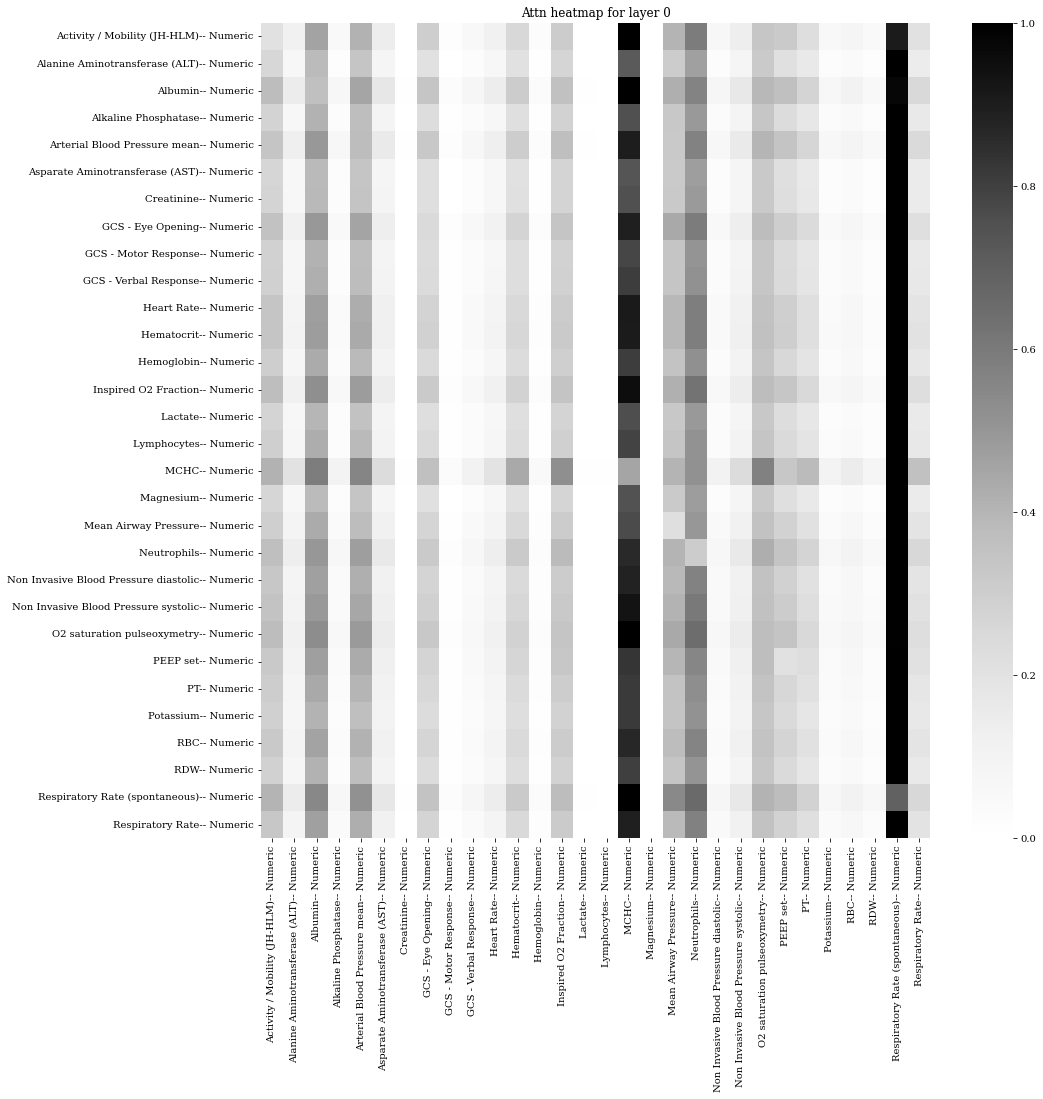

<Figure size 432x288 with 0 Axes>

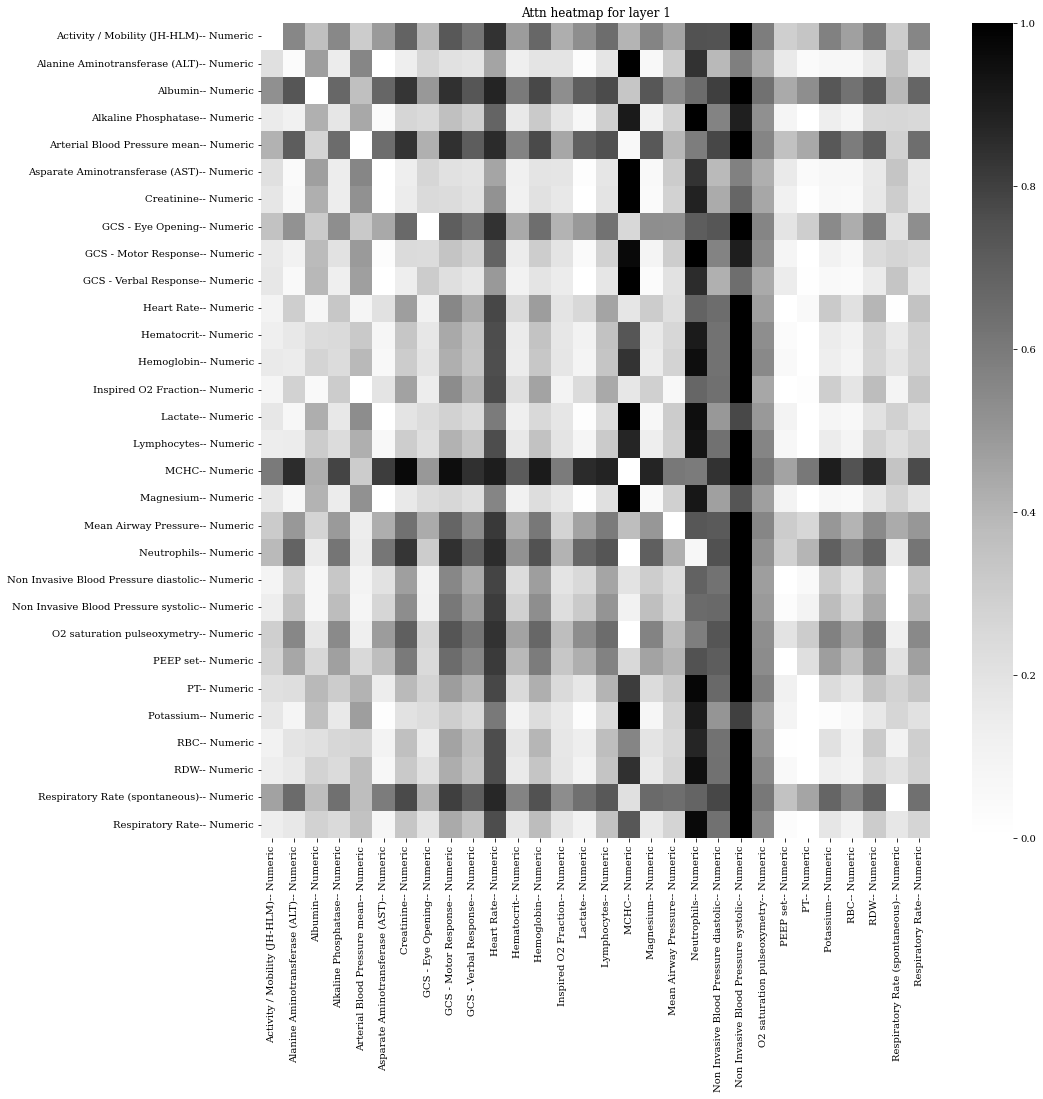

<Figure size 432x288 with 0 Axes>

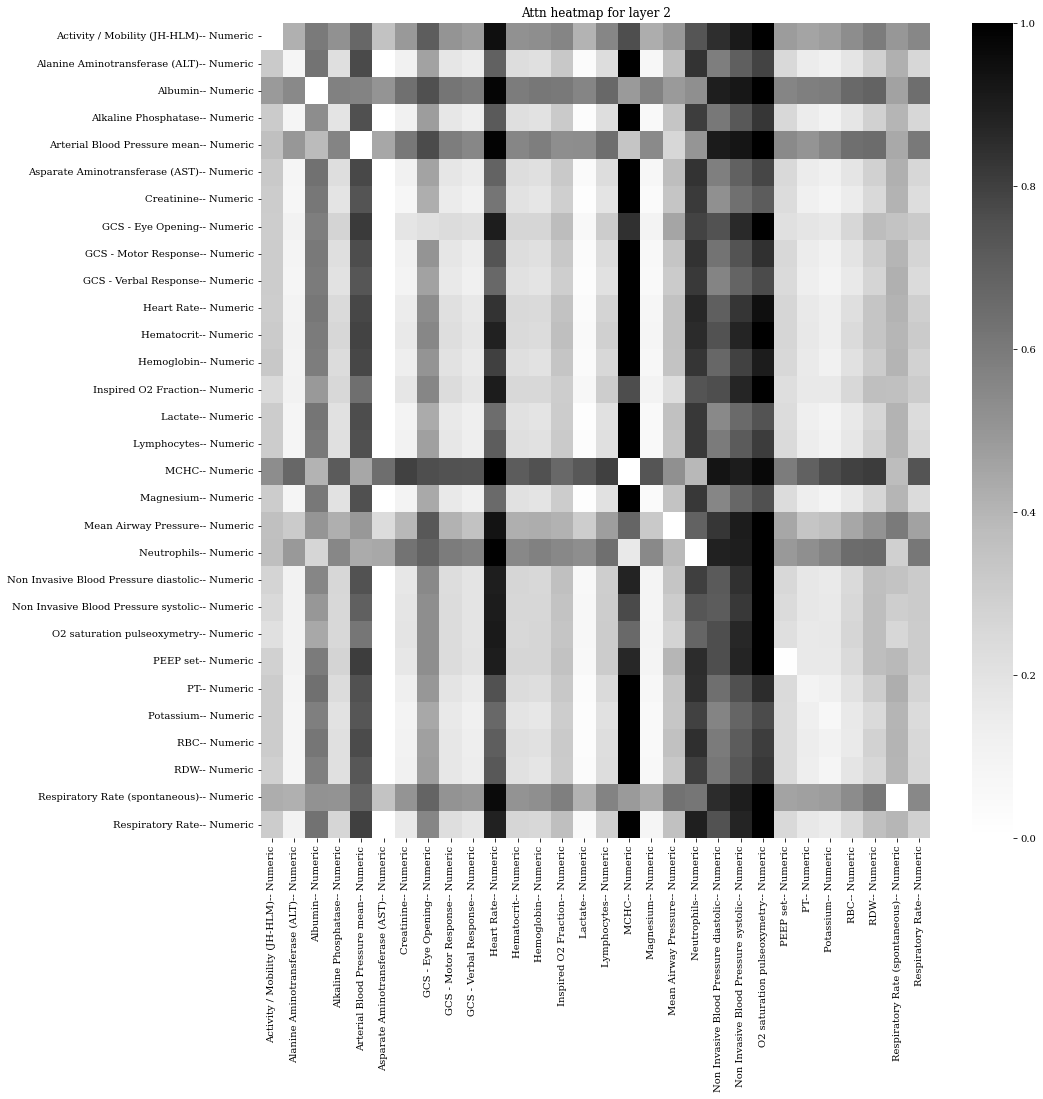

<Figure size 432x288 with 0 Axes>

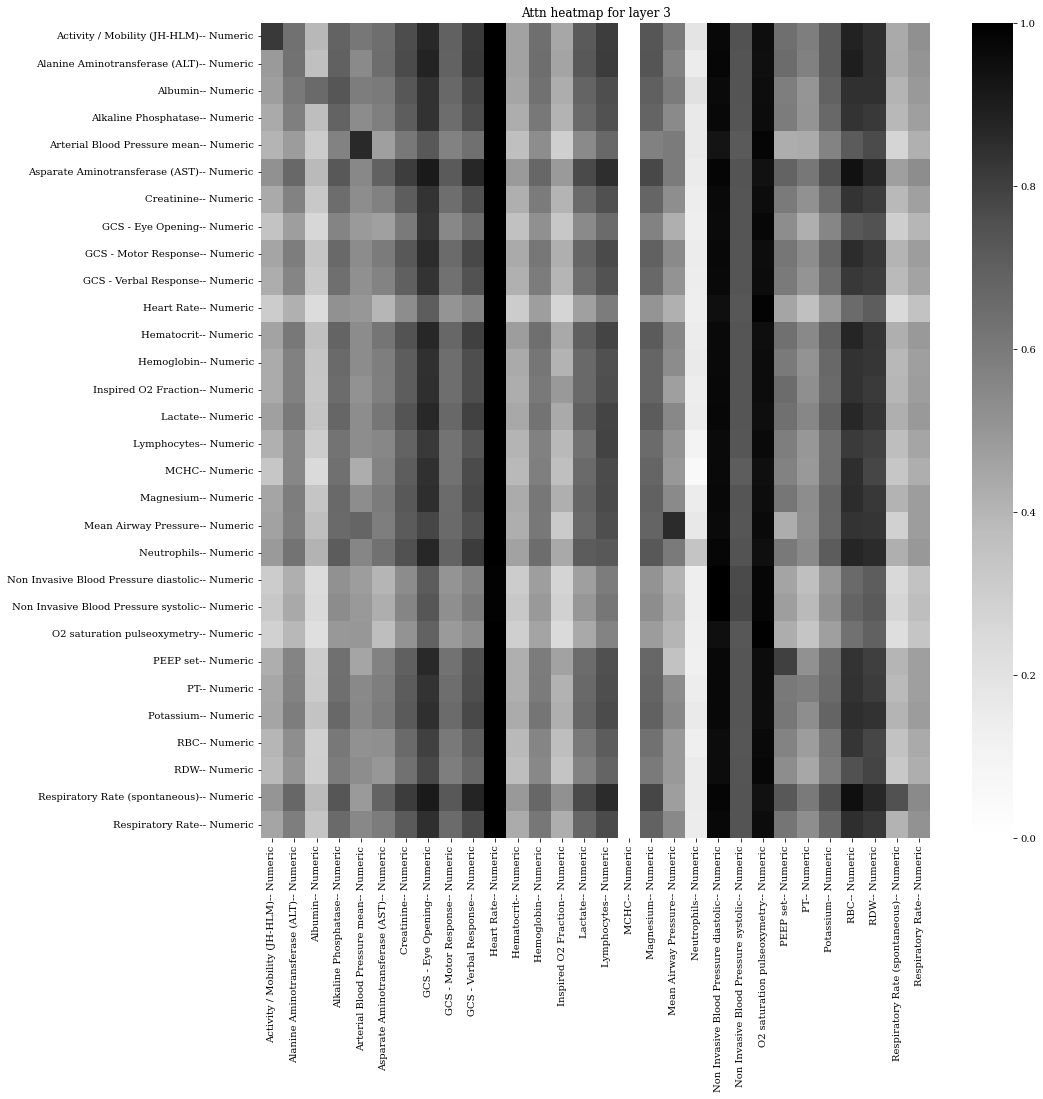

<Figure size 432x288 with 0 Axes>

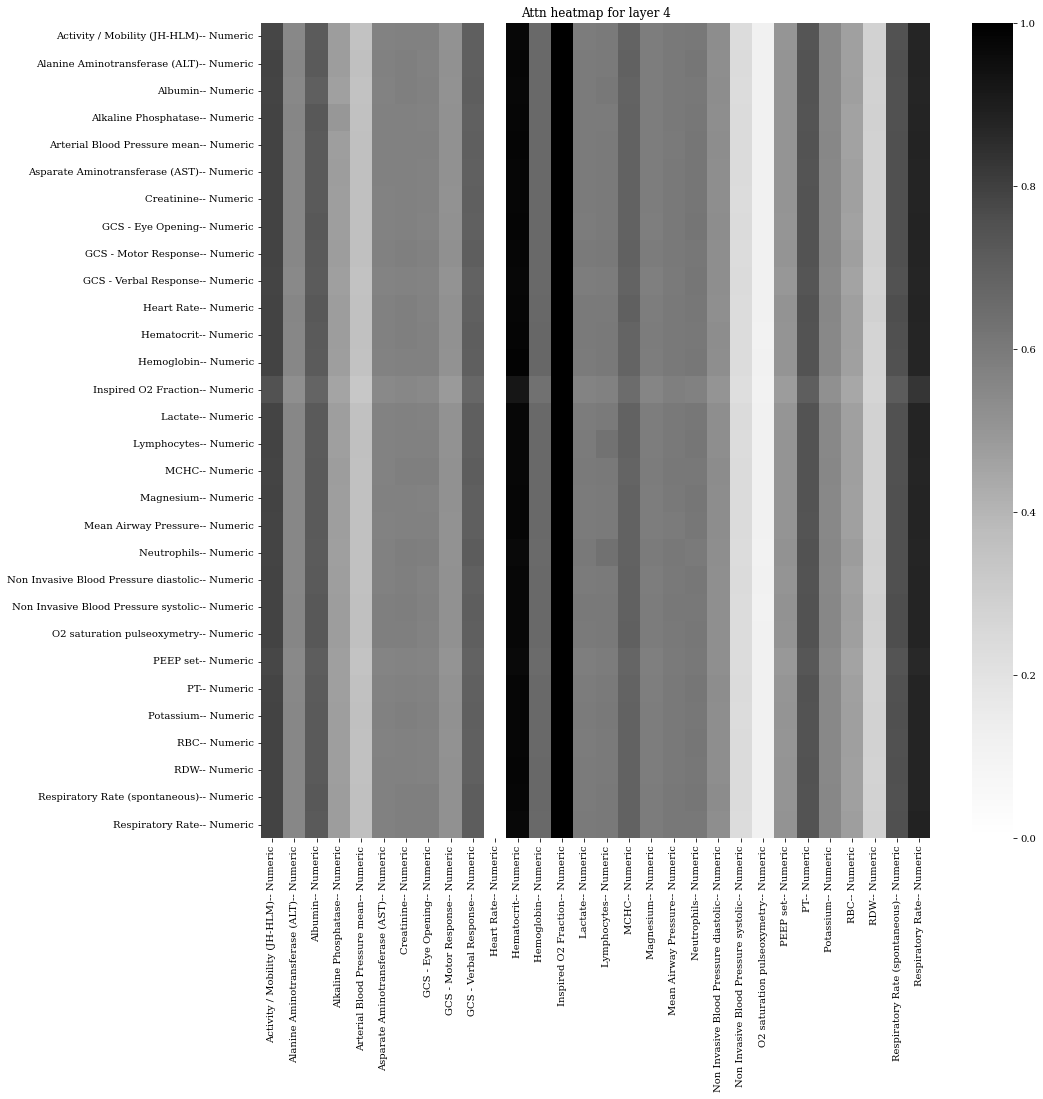

<Figure size 432x288 with 0 Axes>

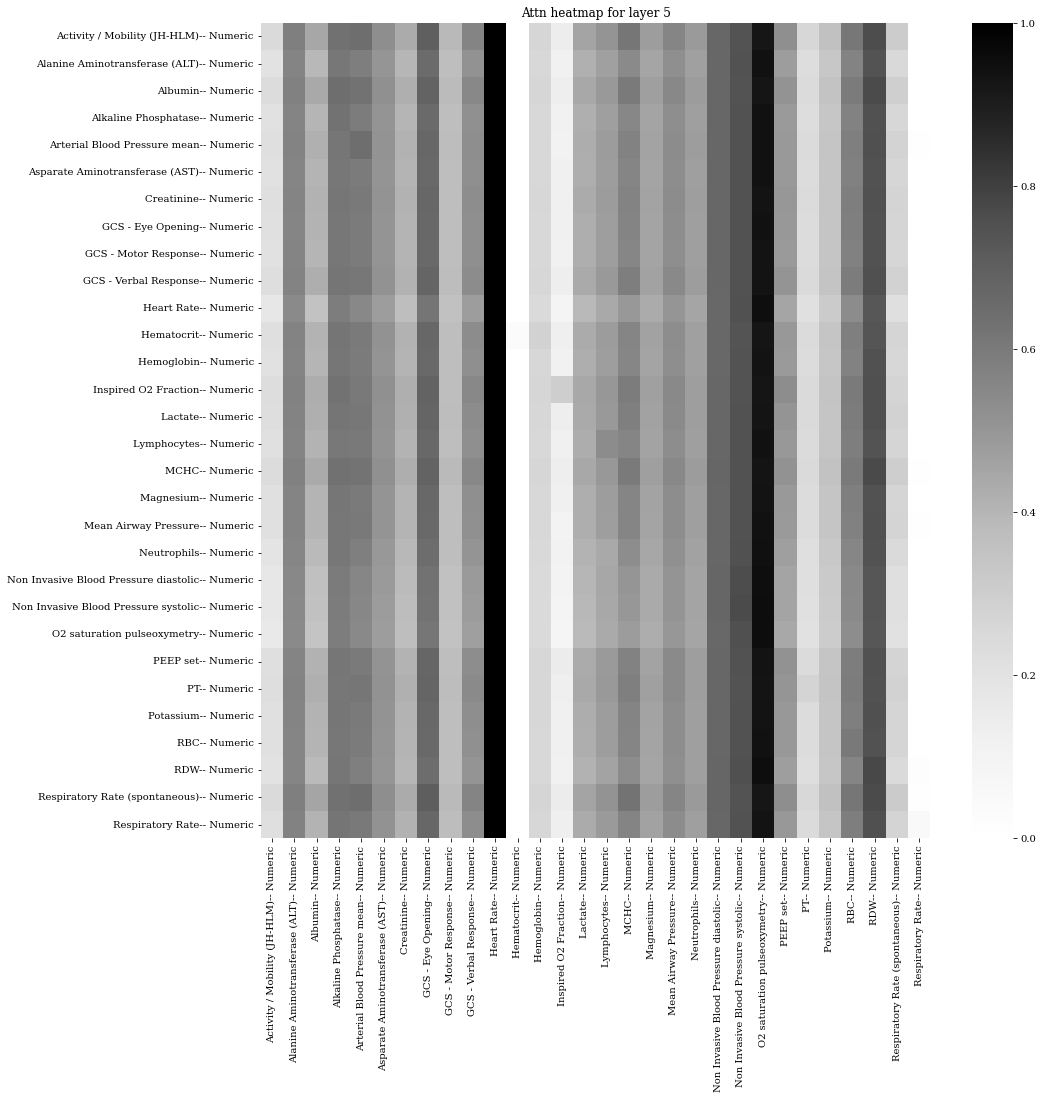

<Figure size 432x288 with 0 Axes>

In [6]:
import seaborn as sns
feature_names = {k: v for k, v in featureSetInfo.numeric_feature_to_index.items() if  v not in dataset_dict['not_good_features']}
feature_names = sorted(feature_names.items(), key = lambda x: x[1])
feature_names = [(y, x) for x, y in enumerate([x for x, _ in feature_names])]
feature_idx =  [x for _,x in feature_names]
feature_names = [x for x, _ in feature_names]
for i, layer_attn in enumerate(new_attn):
    fig, ax = plt.subplots(figsize=(15,15))
    normalized_layer_attn = layer_attn 
    normalized_layer_attn = layer_attn 
    for t in range(normalized_layer_attn.shape[0]):
        normalized_layer_attn[t, :] = (layer_attn[t, :] - layer_attn[t, :].min()) / (layer_attn[t, :].max() - layer_attn[t, :].min())
    #normalized_layer_attn = (layer_attn - layer_attn.min()) / (layer_attn.max() - layer_attn.min())
    sns.heatmap(normalized_layer_attn[feature_idx, :][:, feature_idx], cmap = "Greys",
     xticklabels = feature_names, yticklabels = feature_names, ax = ax ).set(title = 'Attn heatmap for layer '+ str(i))
    plt.show()
    plt.clf()


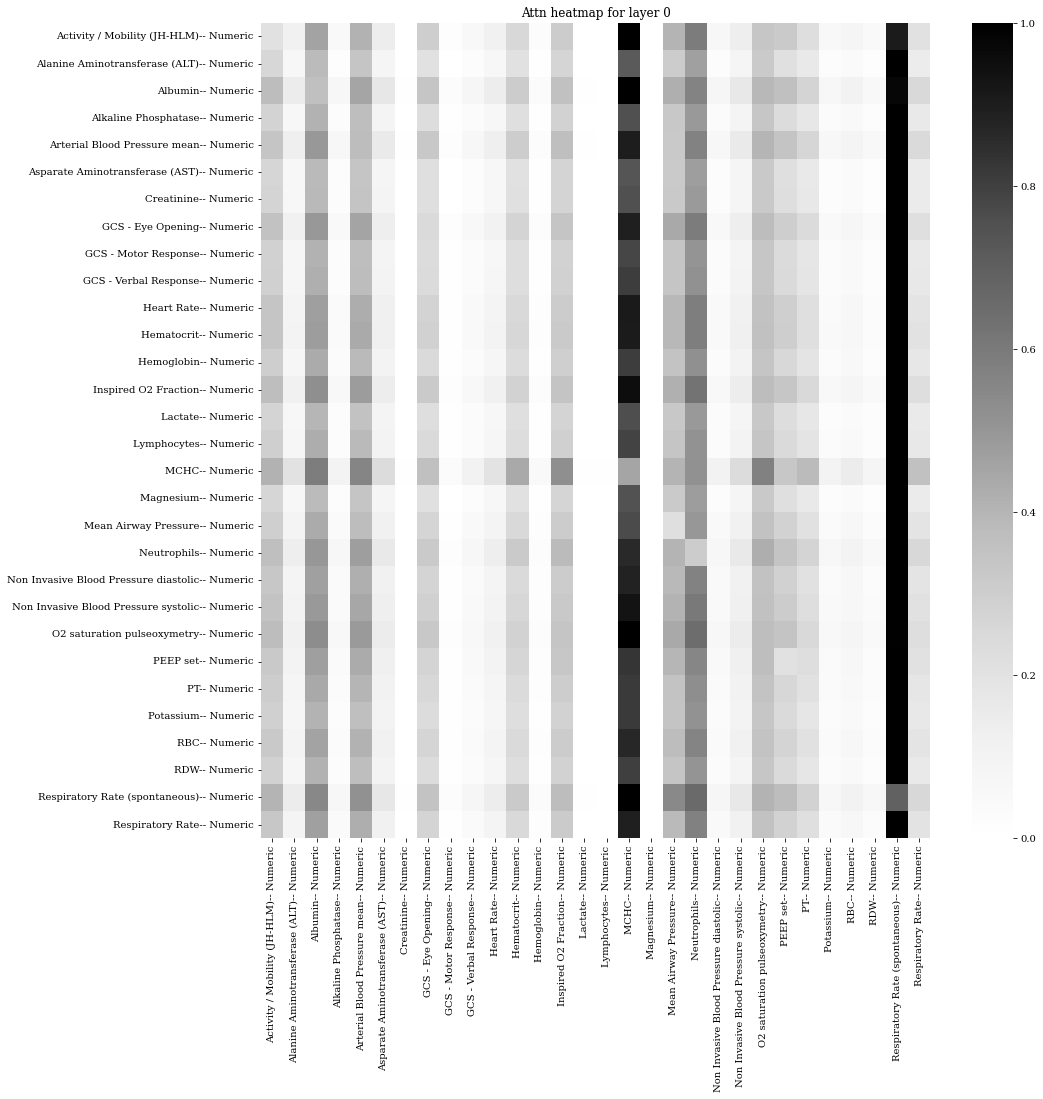

<Figure size 432x288 with 0 Axes>

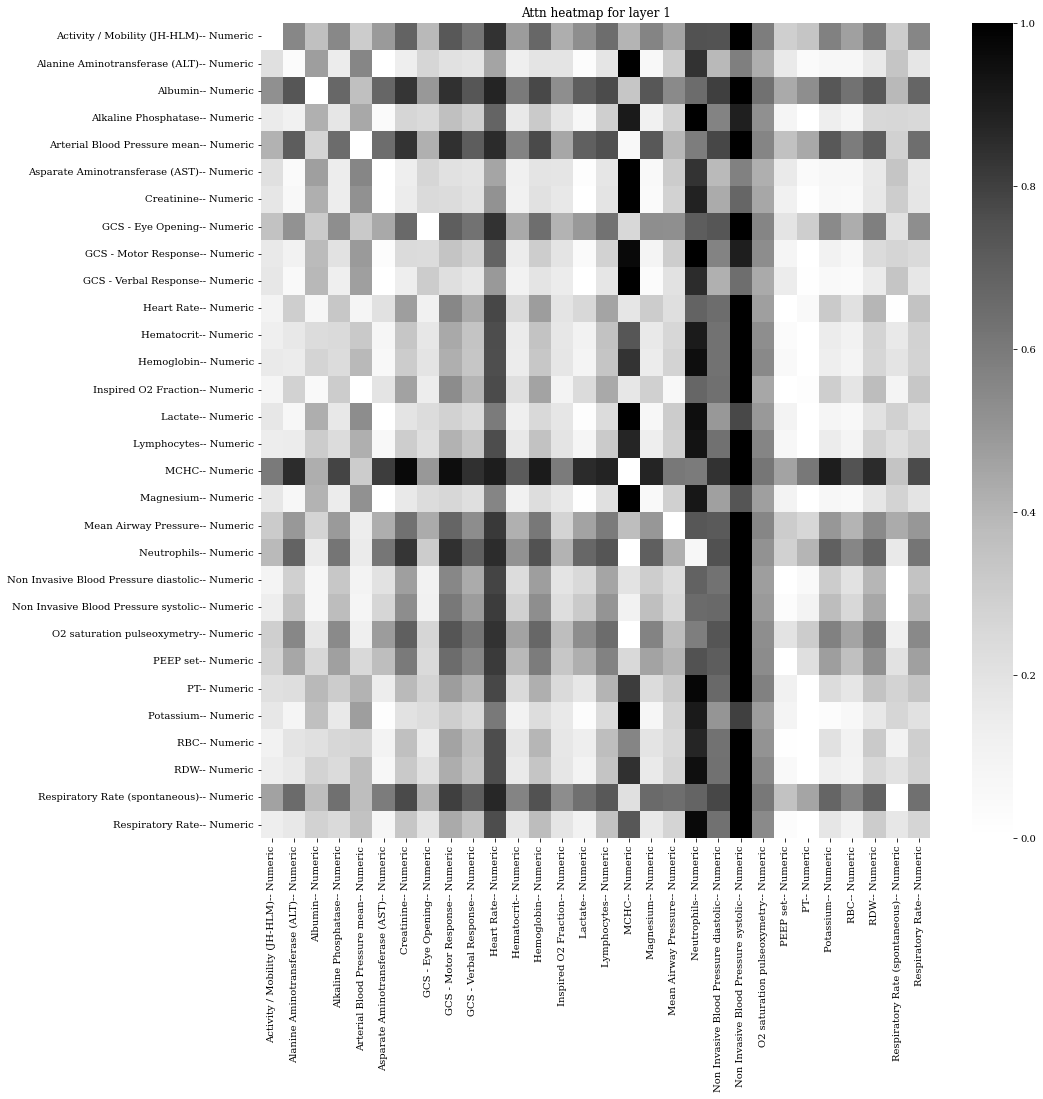

<Figure size 432x288 with 0 Axes>

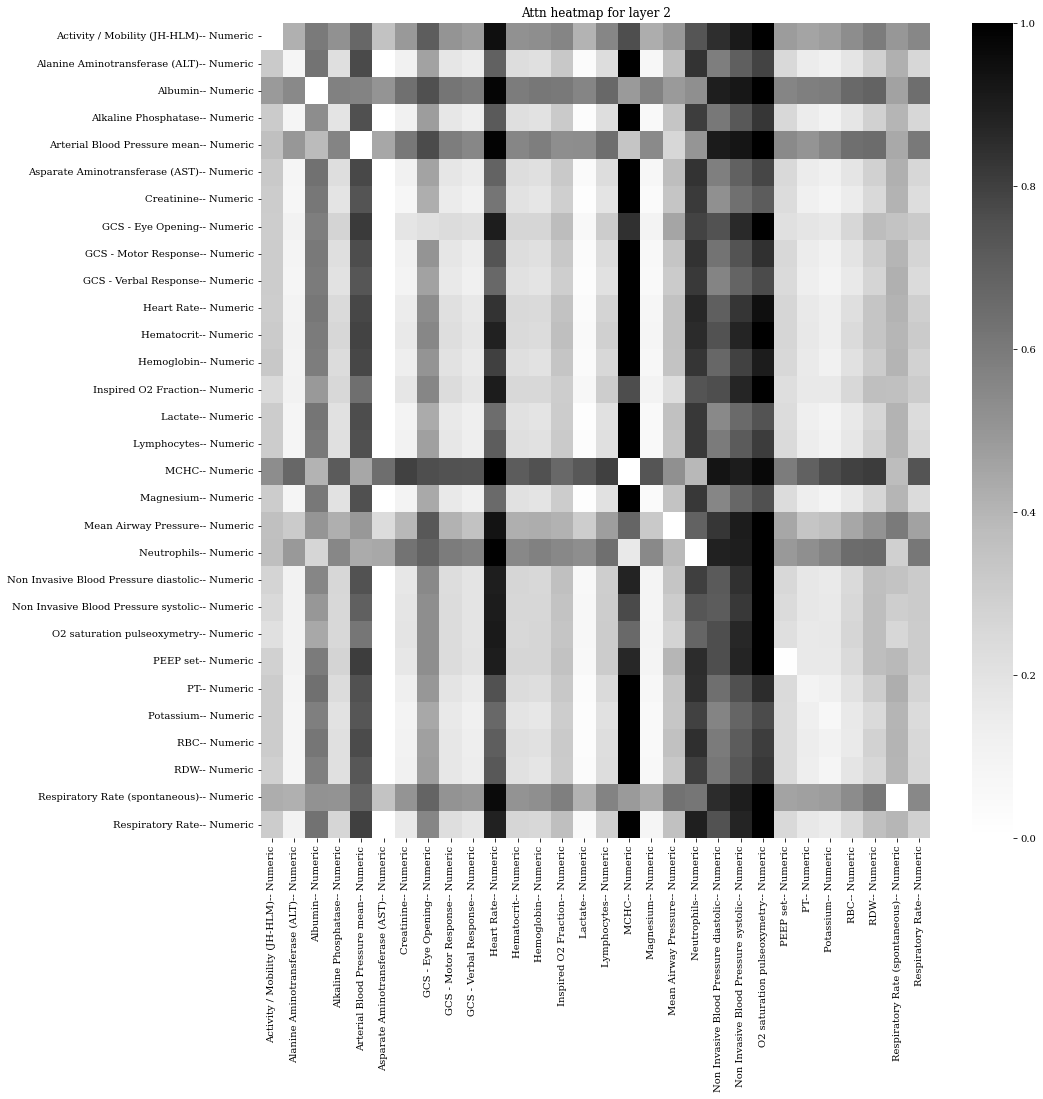

<Figure size 432x288 with 0 Axes>

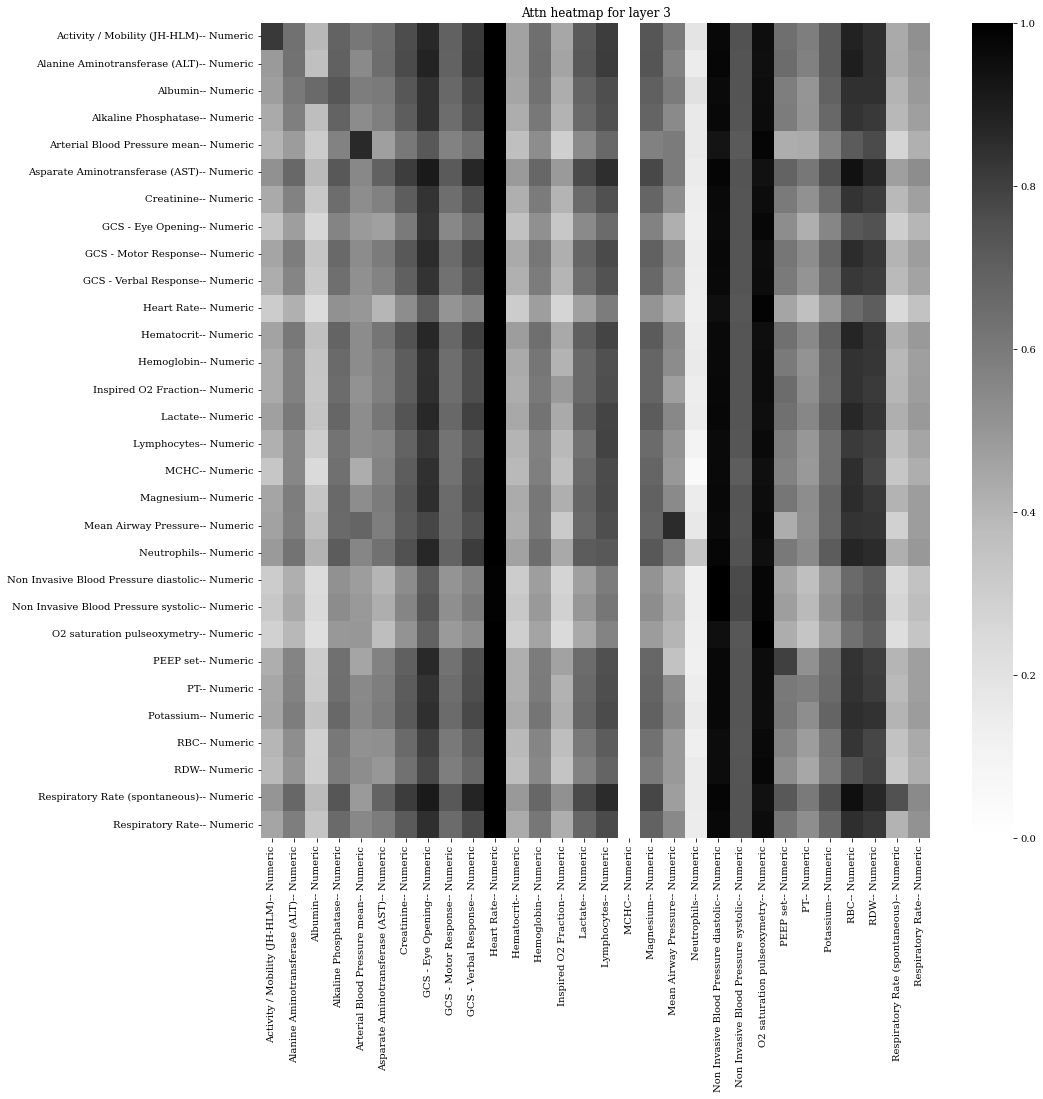

<Figure size 432x288 with 0 Axes>

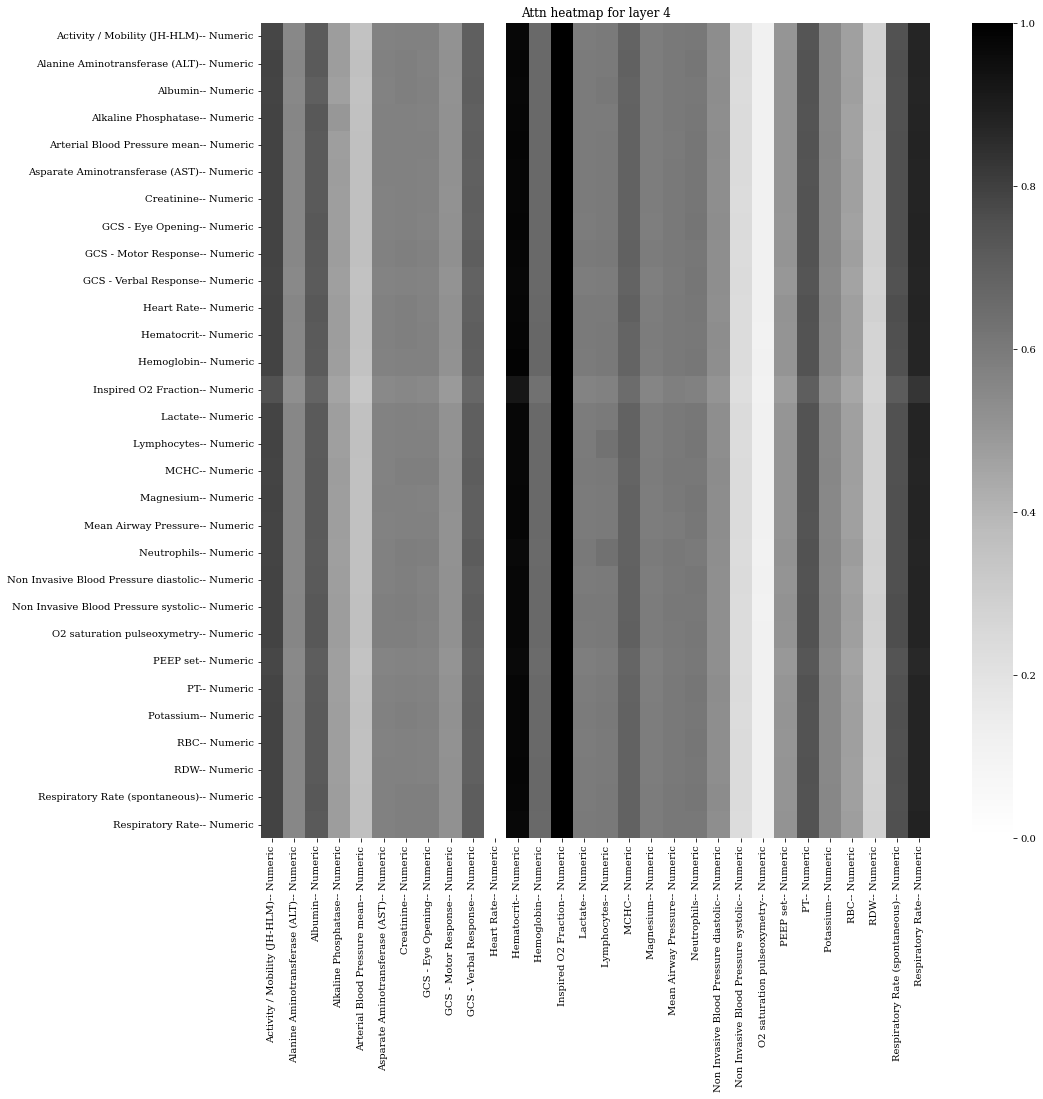

<Figure size 432x288 with 0 Axes>

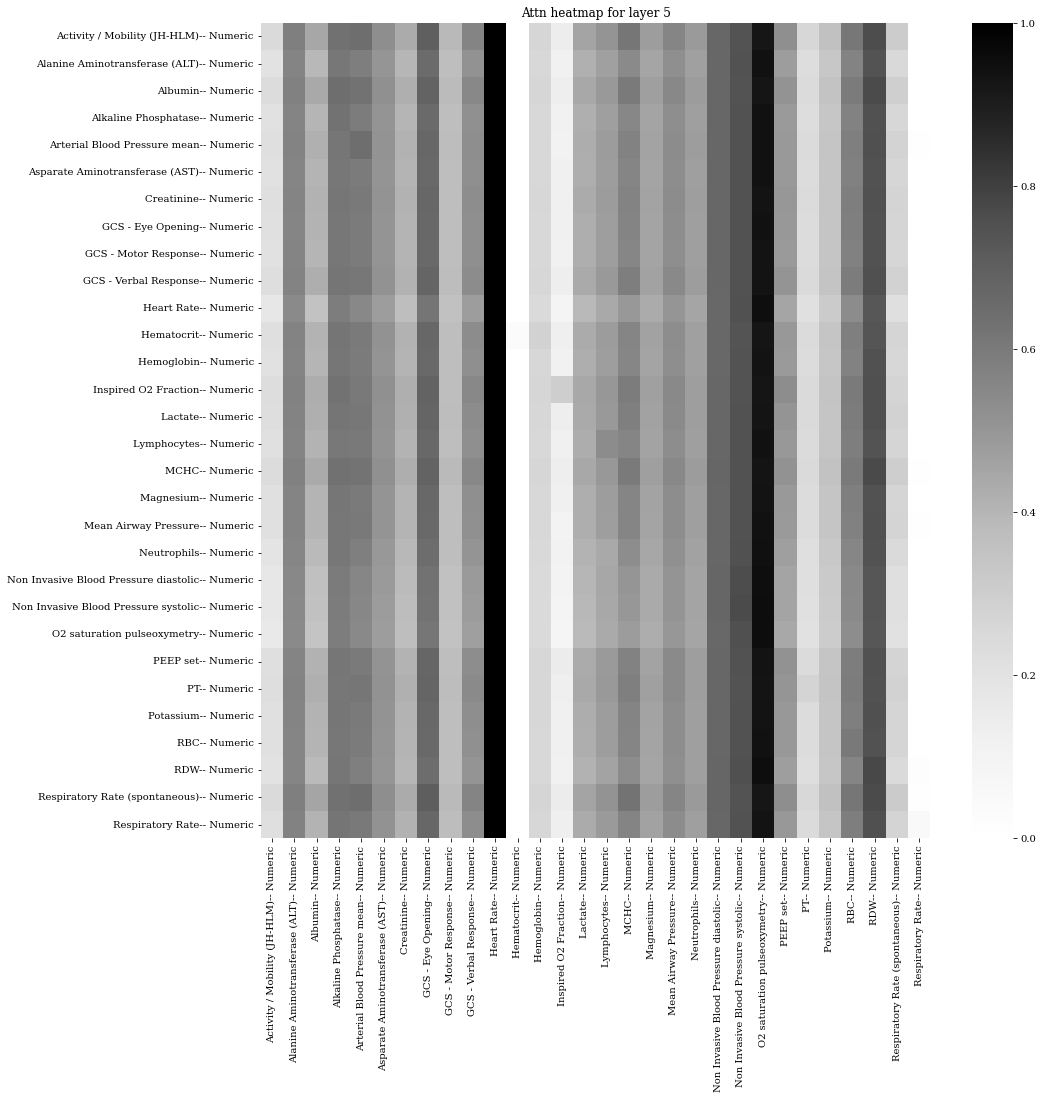

<Figure size 432x288 with 0 Axes>

In [7]:
import seaborn as sns
feature_names = {k: v for k, v in featureSetInfo.numeric_feature_to_index.items() if  v not in dataset_dict['not_good_features']}
feature_names = sorted(feature_names.items(), key = lambda x: x[1])
feature_names = [(y, x) for x, y in enumerate([x for x, _ in feature_names])]
feature_idx =  [x for _,x in feature_names]
feature_names = [x for x, _ in feature_names]
for i, layer_attn in enumerate(new_attn):
    fig, ax = plt.subplots(figsize=(15,15))
    normalized_layer_attn = layer_attn 
    normalized_layer_attn = layer_attn 
    for t in range(normalized_layer_attn.shape[0]):
        normalized_layer_attn[t, :] = layer_attn[t, :] #(layer_attn[t, :] - layer_attn[t, :].min()) / (layer_attn[t, :].max() - layer_attn[t, :].min())
    #normalized_layer_attn = (layer_attn - layer_attn.min()) / (layer_attn.max() - layer_attn.min())
    sns.heatmap(normalized_layer_attn[feature_idx, :][:, feature_idx], cmap = "Greys", vmin = 0, vmax = 1,
     xticklabels = feature_names, yticklabels = feature_names, ax = ax ).set(title = 'Attn heatmap for layer '+ str(i))
    plt.show()
    plt.clf()


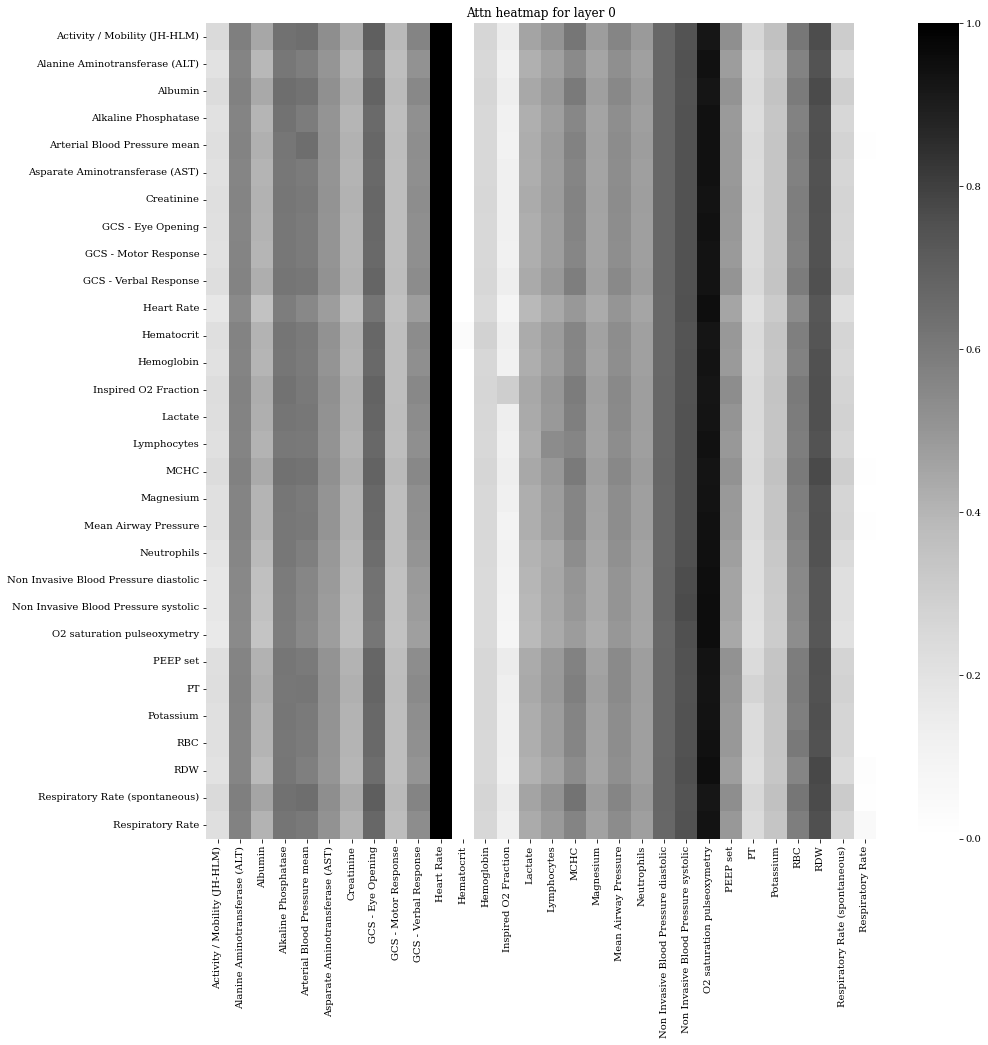

<Figure size 432x288 with 0 Axes>

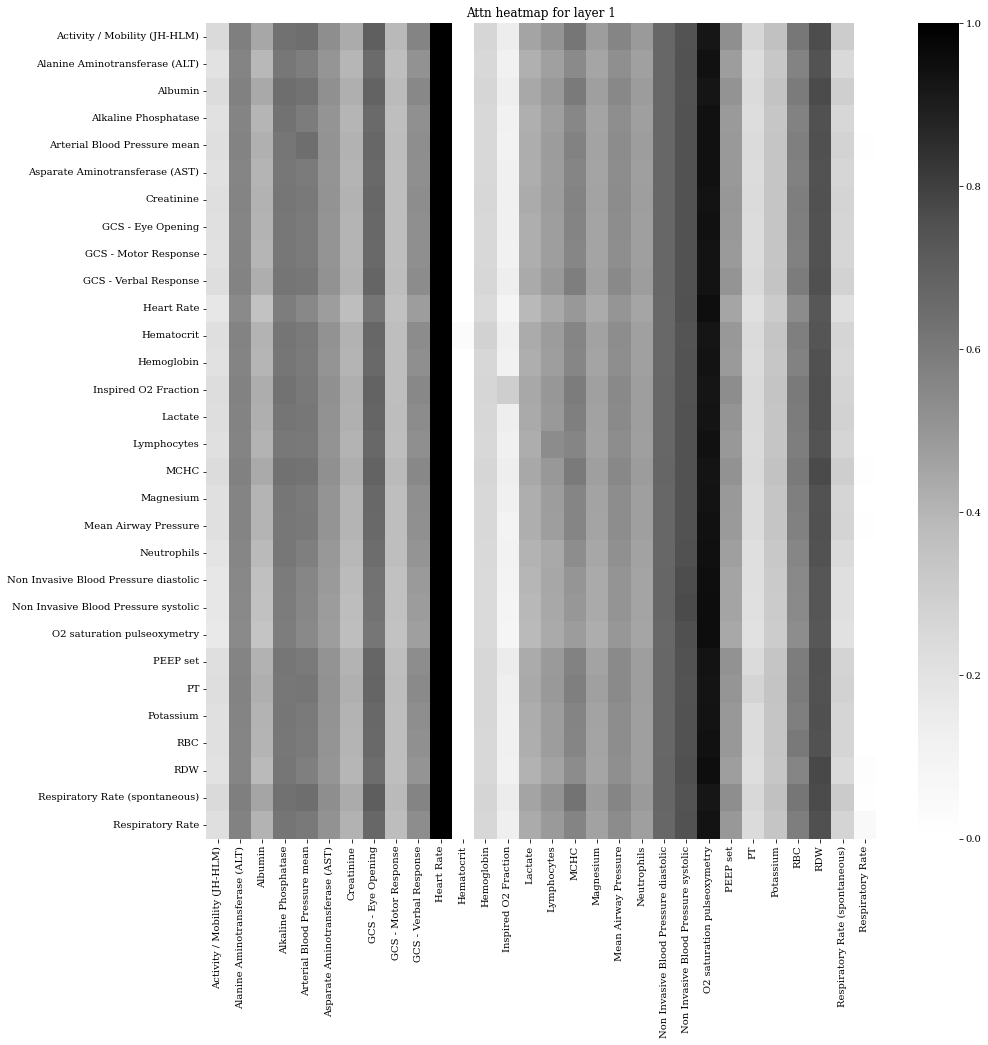

<Figure size 432x288 with 0 Axes>

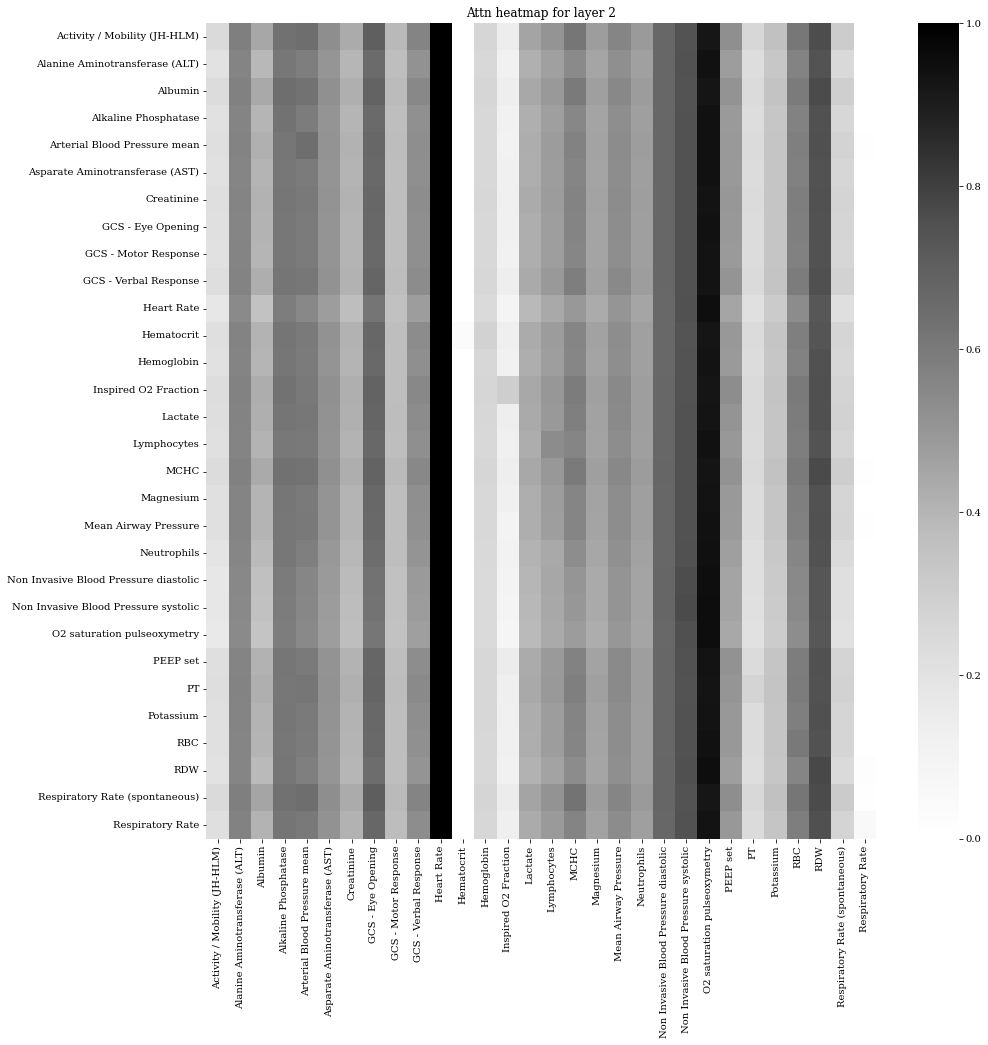

<Figure size 432x288 with 0 Axes>

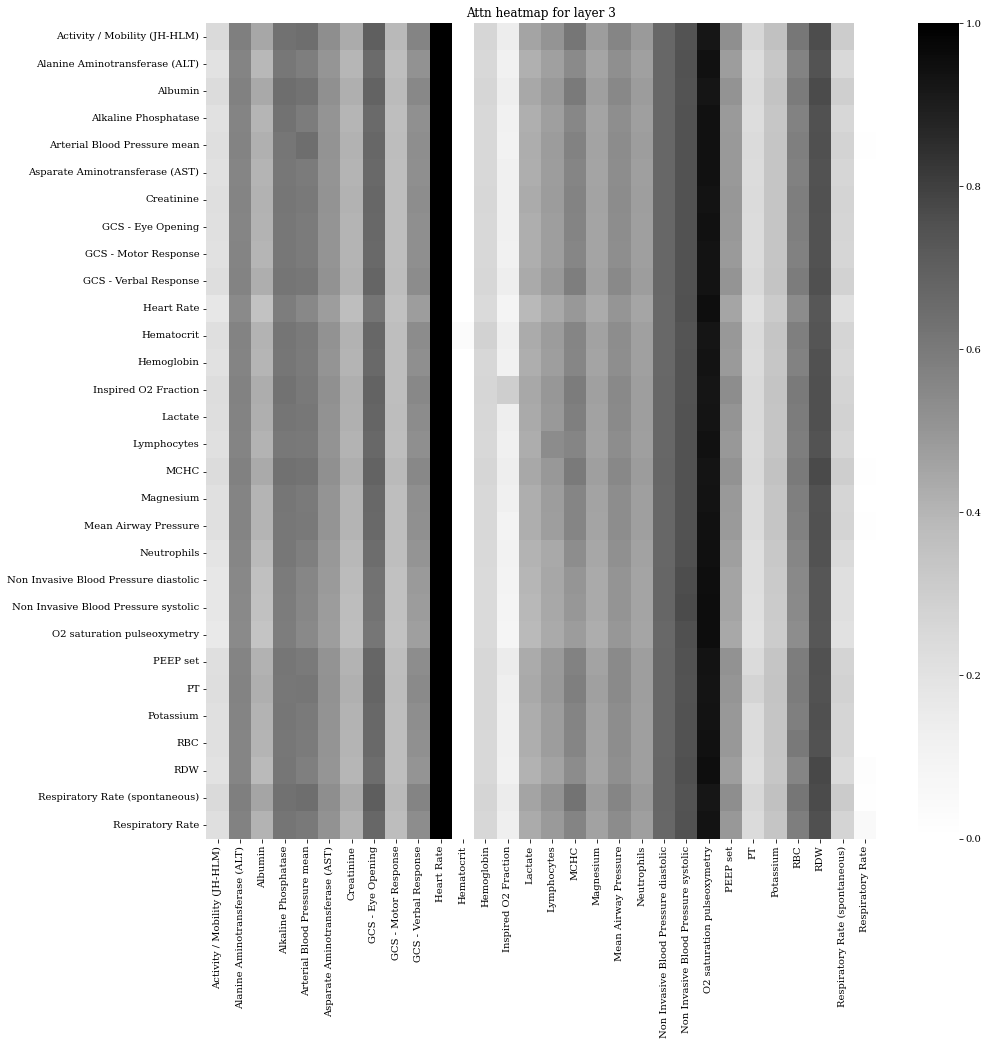

<Figure size 432x288 with 0 Axes>

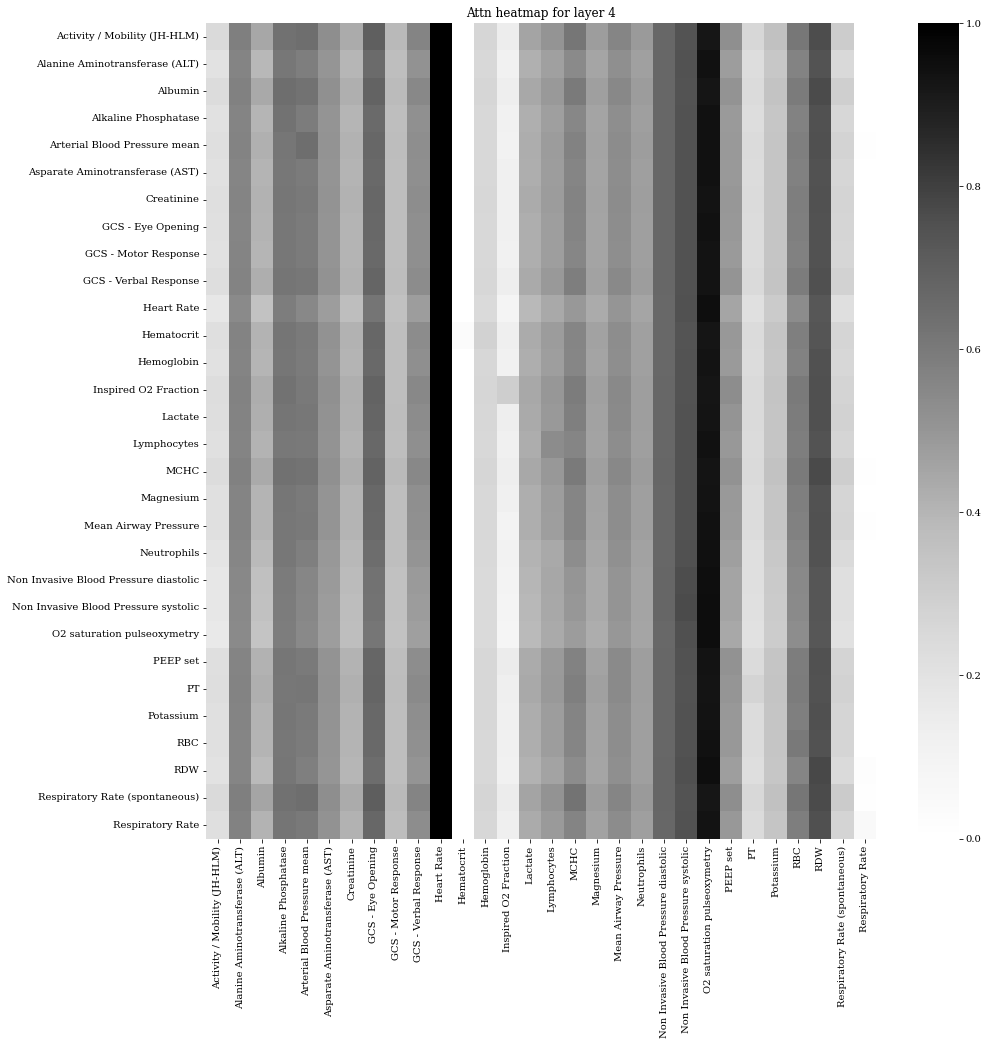

<Figure size 432x288 with 0 Axes>

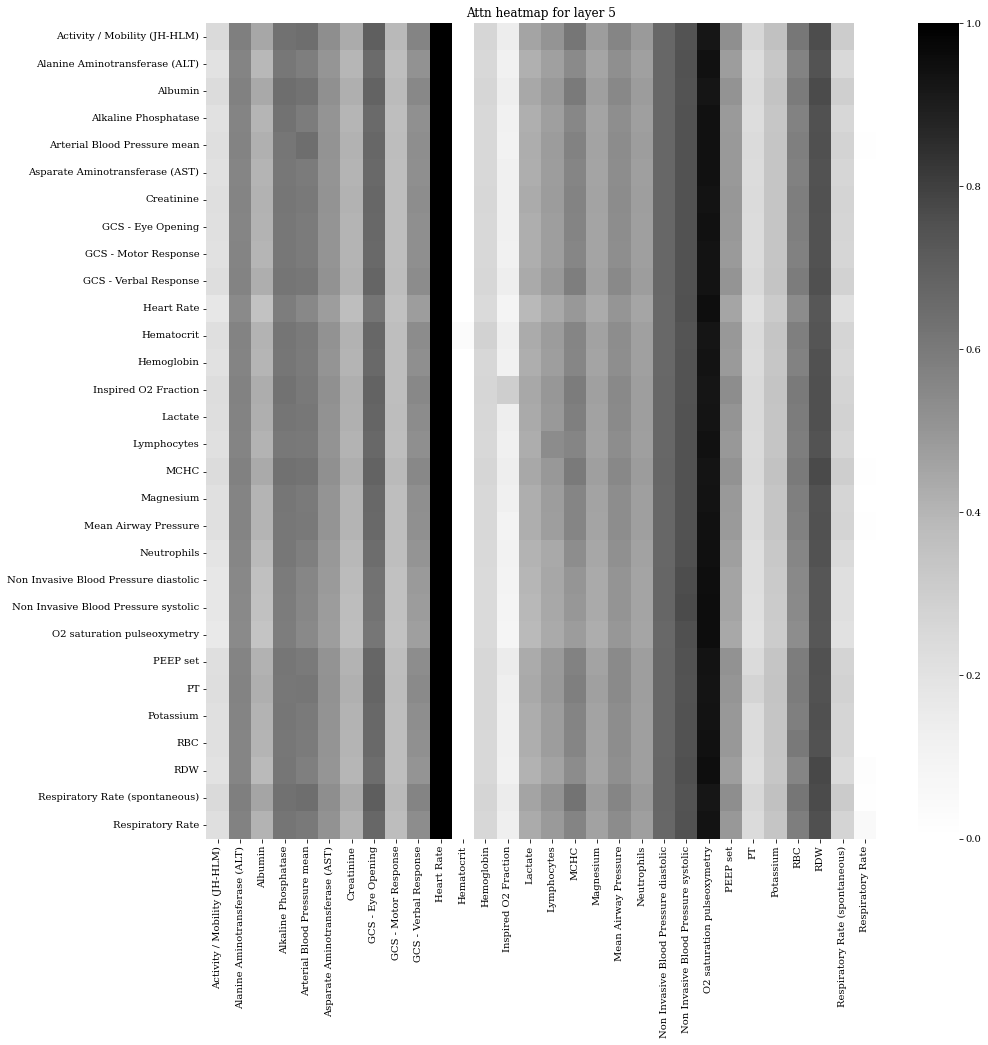

<Figure size 432x288 with 0 Axes>

In [8]:
import seaborn as sns
feature_names = {k: v for k, v in featureSetInfo.numeric_feature_to_index.items() if  v not in dataset_dict['not_good_features']}
feature_names = sorted(feature_names.items(), key = lambda x: x[1])
feature_names = [(y, x) for x, y in enumerate([x for x, _ in feature_names])]
feature_idx =  [x for _,x in feature_names]
# feature_names = [x for x, _ in feature_names]
feature_names_d = {k: v for k, v in featureSetInfo.feature_codes_to_id.items() if  v + len(featureSetInfo.numeric_feature_to_index) + featureSetInfo.num_non_numeric_features not in dataset_dict['not_good_features']}
feature_names_d = sorted(feature_names_d.items(), key = lambda x: x[1])
feature_names_d = [(y, x) for x, y in enumerate([x for x, _ in feature_names_d])]
feature_names = [x for x, _ in feature_names] + [x for x, _ in feature_names_d]
relevant = feature_names #['Activity / Mobility (JH-HLM)-- Numeric', 'Potassium-- Numeric', 'MCHC-- Numeric', 'GCS - Verbal Response-- Numeric', 
            #'Lactate-- Numeric', 'Albumin-- Numeric', 'GCS - Motor Response-- Numeric', 'Creatinine-- Numeric']
feature_idx = [x for x, y in enumerate(feature_names) if y in relevant]
feature_names = [x[:x.index('--')] for x in feature_names if x in relevant]
for i, layer_attn in enumerate(new_attn):
    fig, ax = plt.subplots(figsize=(15,15))
    #normalized_layer_attn = torch.nn.functional.softmax(layer_attn, dim = 1)
    normalized_layer_attn = (normalized_layer_attn - normalized_layer_attn.min()) / (normalized_layer_attn.max() - normalized_layer_attn.min())
    sns.heatmap(normalized_layer_attn[feature_idx, :][:, feature_idx], cmap = "Greys", vmin = 0, vmax = 1,
     xticklabels = feature_names, yticklabels = feature_names, ax = ax ).set(title = 'Attn heatmap for layer '+ str(i))
    plt.show()
    plt.clf()


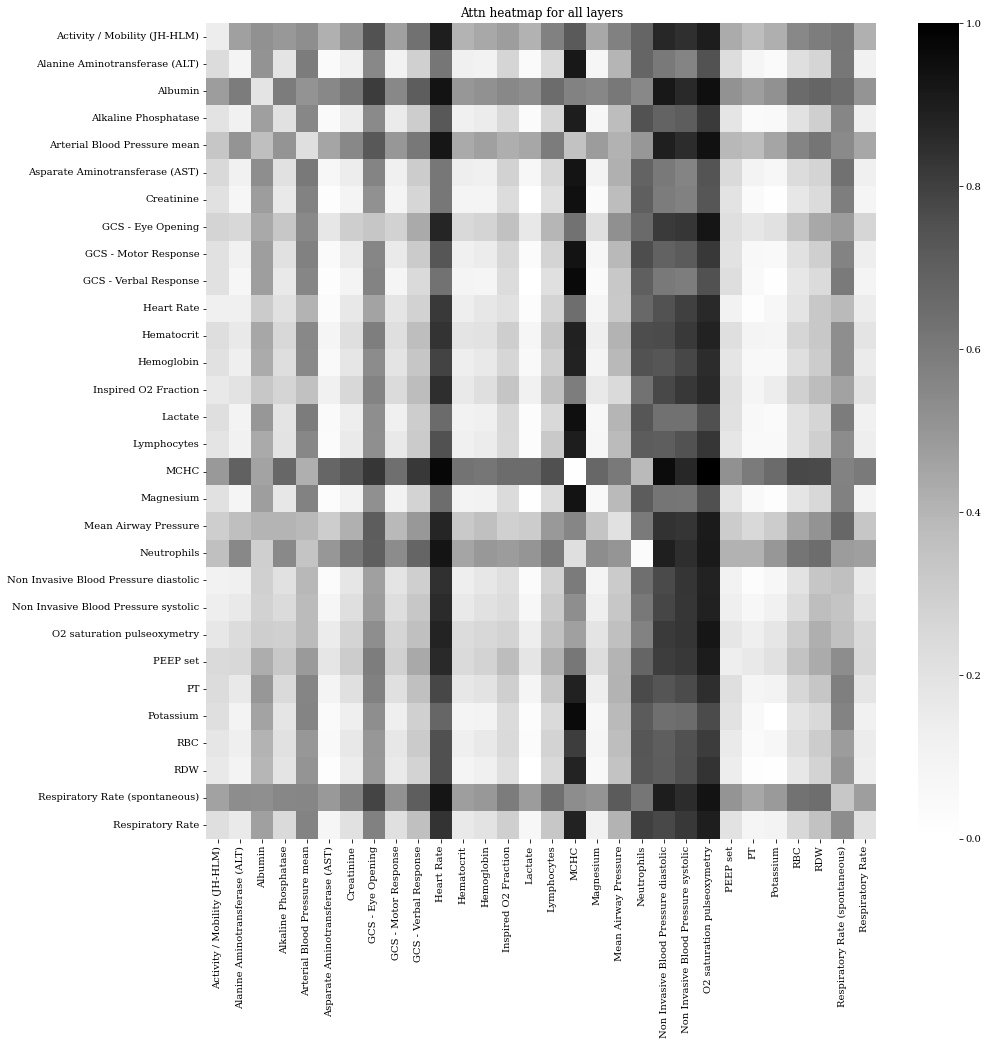

<Figure size 432x288 with 0 Axes>

In [9]:
layer_attn = torch.mean(torch.cat([x.unsqueeze(0) for x in new_attn], dim = 0), dim = 0)
fig, ax = plt.subplots(figsize=(15,15))
normalized_layer_attn = (layer_attn - layer_attn.min()) / (layer_attn.max() - layer_attn.min())
sns.heatmap(normalized_layer_attn[feature_idx, :][:, feature_idx], cmap = "Greys",
xticklabels = feature_names, yticklabels = feature_names, ax = ax ).set(title = 'Attn heatmap for all layers')
plt.show()
plt.clf()